In [3]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import copy
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from scipy.fft import fft
from scipy.signal import stft
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from Flight import Flight
from IPython.display import clear_output

from FlightTracker import FlightTracker

'''
import importlib
import FlightTracker
importlib.reload(FlightTracker)
from FlightTracker import FlightTracker
'''
#tracker = FlightTracker('2023-05-12 14:28:54', '2023-05-12 16:24:02')
#tracker = FlightTracker('2023-05-07 13:38:34',	'2023-05-07 13:56:44')#CPA085
tracker = FlightTracker('2022-08-23 14:57:27', '2022-08-23 17:30:27')
print(tracker.get_times())
tracker.flights_distinct

"2022-08-23T14:57:27" "2022-08-23T17:30:27"
None


,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta
0,0,SKIER31,2022-08-23,2022.08.24-045241.db,2022-08-23 14:57:27.300000,2022-08-23 17:30:22.000000,0.8,0.0,47.0
1,1,N/A,2022-08-23,2022.08.24-045241.db,2022-08-23 15:45:31.400000,2022-08-23 15:45:41.400000,0.9,0.0,46.0


In [4]:
tracker.header_df = FlightTracker.get_df_from_handcarry_data(tracker.start_time, tracker.stop_time, stations = [11])

Not processing station station12
Not processing station station12
Not processing station station13
Not processing station station13
Not processing station station21
Not processing station station21
Not processing station station22
Not processing station station22
Not processing station station23
Not processing station station23
Not processing station station24
Not processing station station24
./combined_scores_handcarry/station11_run1313_scores.db
./combined_scores_handcarry/station11_run1314_scores.db


In [5]:
header_df = tracker.header_df
header_df

,trigger_time,station_number,radiant_triggers,run_number,event_number,lt_triggers,force_triggers,ext_triggers,index,l1_max,amp_max,SNR_max,RMS_max,imp_max,cw,impulsive
279,1.661267e+09,11,False,1313,279,False,True,False,279,0.031717,0.044967,4.443199,0.011397,0.053428,0,0
280,1.661267e+09,11,False,1313,280,True,False,False,280,0.029022,0.045892,4.980754,0.011397,0.036984,0,0
281,1.661267e+09,11,False,1313,281,True,False,False,281,0.029022,0.048887,5.718400,0.011397,0.040157,0,0
282,1.661267e+09,11,False,1313,282,False,True,False,282,0.026138,0.049084,4.724636,0.011397,0.043063,0,0
283,1.661267e+09,11,False,1313,283,True,False,False,283,0.034860,0.043891,4.510220,0.011397,0.037844,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,1.661276e+09,11,False,1314,1030,True,False,False,1030,0.030577,0.046250,5.126501,0.011120,0.038601,0,0
5804,1.661276e+09,11,False,1314,1031,True,False,False,1031,0.041109,0.044450,5.006054,0.011120,0.039054,0,0
5805,1.661276e+09,11,False,1314,1032,False,True,False,1032,0.050279,0.049472,5.057311,0.011120,0.035015,0,0
5806,1.661276e+09,11,False,1314,1033,True,False,False,1033,0.027898,0.047061,4.738146,0.011120,0.044252,0,0


[Text(0.0, 0, '2022-08-23 15:57:27'),
 Text(281.0, 0, '2022-08-23 16:21:29'),
 Text(562.0, 0, '2022-08-23 16:45:01'),
 Text(844.0, 0, '2022-08-23 18:30:22')]

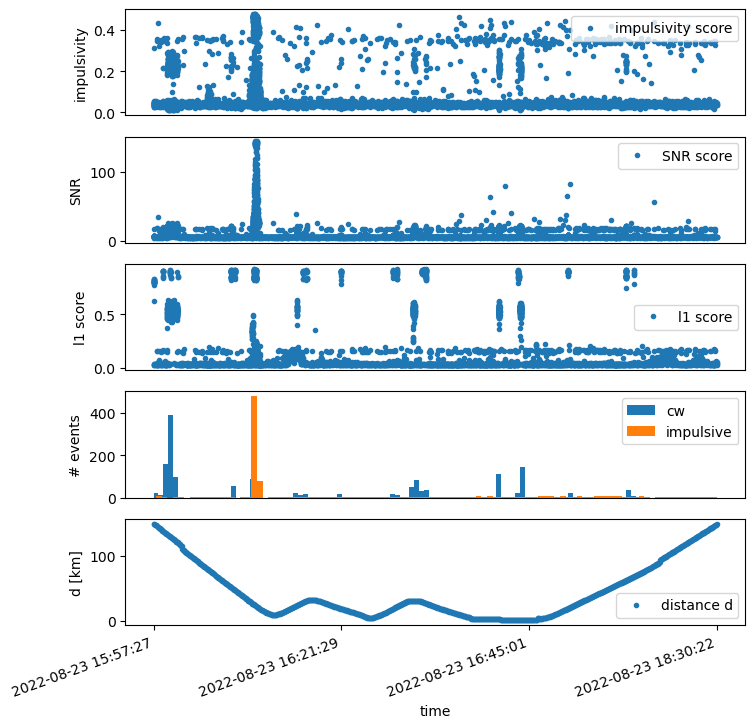

In [6]:
fig, ax = plt.subplots(5, figsize = (8, 8))
ax[0].plot(header_df.trigger_time, header_df.imp_max, '.', label = 'impulsivity score')
ax[1].plot(header_df.trigger_time, header_df.SNR_max, '.', label = 'SNR score')
ax[2].plot(header_df.trigger_time, header_df.l1_max, '.', label = 'l1 score')
ax[3].hist(header_df.trigger_time[header_df.cw == 1], bins = 100, label = 'cw')
ax[3].hist(header_df.trigger_time[header_df.impulsive == 1], bins = 100, label = 'impulsive')
ax[4].plot(tracker.flights.readtime, np.sqrt(tracker.flights.r2), '.', label = 'distance d')
for axes in ax:
    axes.legend()
    axes.set_xticks([])
ax[0].set_ylabel('impulsivity')
ax[1].set_ylabel('SNR')
ax[2].set_ylabel('l1 score')
ax[3].set_ylabel('# events')
ax[4].set_ylabel('d [km]')
ax[4].set_xlabel('time')

num_ticks = 4
xticks = np.linspace(0, len(tracker.flights.readtime) - 1, num_ticks).astype(int)
tick_labels = [tracker.flights.readtime.iloc[i][:19] for i in xticks]
ax[4].set_xticks(tracker.flights.readtime[xticks])
ax[4].set_xticklabels(tick_labels, rotation=20, ha='right')


Text(0, 0.5, 'impulsivity score (max of 24 channels)')

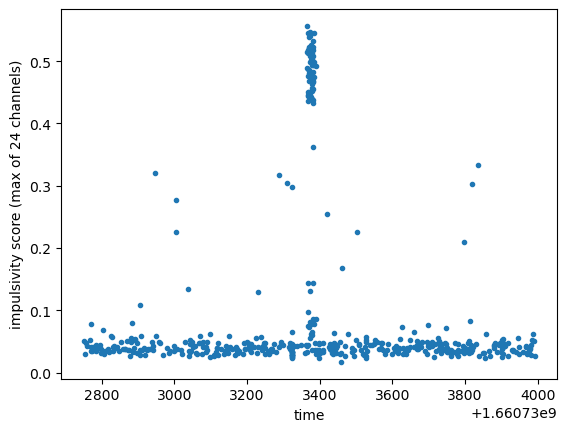

In [9]:
plt.plot(header_df.trigger_time, header_df.imp_max, '.')
plt.xlabel('time')
plt.ylabel('impulsivity score (max of 24 channels)')

Text(0, 0.5, 'SNR (max of 24 channels)')

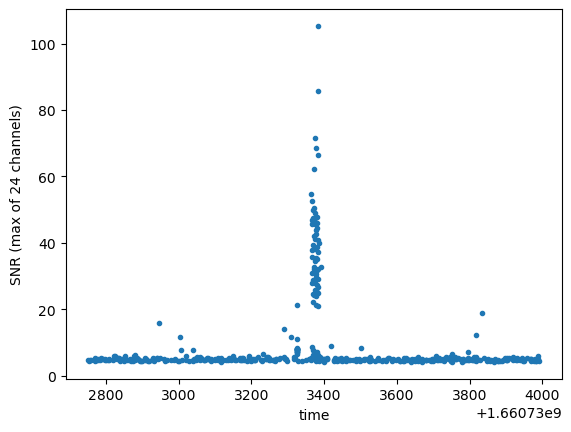

In [11]:
plt.plot(header_df.trigger_time, header_df.SNR_max, '.')
plt.xlabel('time')
plt.ylabel('SNR (max of 24 channels)')

In [ ]:
plt.plot(header_df.trigger_time, header_df.imp_max, '.')
plt.xlabel('time')
plt.ylabel('impulsivity score (max of 24 channels)')

In [3]:
impulsive_df = tracker.header_df.copy()#tracker.header_df[(tracker.header_df.impulsive == 1)].copy()
impulsive_df['trigger_time_sec'] = (impulsive_df['trigger_time']).astype(np.int64)
impulsive_df['trigger_time_millis'] = (impulsive_df['trigger_time'] * (10 ** 3)).astype(np.int64)
impulsive_df

,trigger_time,station_number,radiant_triggers,run_number,event_number,lt_triggers,force_triggers,ext_triggers,index,l1_max,amp_max,SNR_max,RMS_max,imp_max,cw,impulsive,trigger_time_sec,trigger_time_millis
44,1.660733e+09,11,False,1239,44,True,False,False,44,0.031826,0.051112,4.891509,0.011112,0.050723,0,0,1660732751,1660732751565
45,1.660733e+09,11,False,1239,45,True,False,False,45,0.024803,0.042131,4.581288,0.011112,0.030130,0,0,1660732753,1660732753512
46,1.660733e+09,11,False,1239,46,True,False,False,46,0.026706,0.051320,4.811699,0.011112,0.046791,0,0,1660732755,1660732755936
47,1.660733e+09,11,False,1239,47,False,True,False,47,0.030451,0.042690,4.689539,0.011112,0.042848,0,0,1660732758,1660732758770
48,1.660733e+09,11,False,1239,48,False,True,False,48,0.030759,0.041559,4.399311,0.011112,0.052492,0,0,1660732768,1660732768805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27233,1.660734e+09,24,True,385,2132,False,False,False,2132,0.025830,0.045989,5.079582,0.013120,0.048809,0,0,1660733987,1660733987188
27234,1.660734e+09,24,False,385,2133,True,False,False,2133,0.025305,0.045867,5.094392,0.013120,0.033621,0,0,1660733987,1660733987795
27235,1.660734e+09,24,True,385,2134,False,False,False,2134,0.048875,0.045542,5.070554,0.013120,0.036268,0,0,1660733987,1660733987971
27236,1.660734e+09,24,False,385,2135,True,False,False,2135,0.032390,0.049914,4.873191,0.013120,0.032302,0,0,1660733988,1660733988296


In [4]:
flights_distinct = tracker.flights_distinct
flights_distinct = sqldf(''' 
SELECT
    *
    ,date || '_' || flightnumber as fk_date_flightnumber
FROM flights_distinct
''')
flights = tracker.flights
flights = sqldf(''' 
SELECT
    *
    ,date(readtime) || '_' || flightnumber as fk_date_flightnumber
FROM flights
''')

flights_distinct['mintime'] = pd.to_datetime(flights_distinct.mintime).dt.tz_localize('UTC')
flights_distinct['maxtime'] = pd.to_datetime(flights_distinct.maxtime).dt.tz_localize('UTC')

flights_distinct['mintime_millis'] = flights_distinct.mintime.astype(np.int64) // 10 ** 6
flights_distinct['maxtime_millis'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 6

flights_distinct['mintime_sec'] = flights_distinct.mintime.astype(np.int64) // 10 ** 9
flights_distinct['maxtime_sec'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 9

flights_distinct['ID'] = flights_distinct.index

In [5]:
query = ''' 
SELECT
    count(trigger_time_sec) as sum_triggers_per_second
    --,station_number
    ,trigger_time_sec
    --,CASE 
    --    WHEN force_triggers = 1 THEN 1
    --    WHEN lt_triggers = 1 THEN 2
    --    WHEN radiant_triggers = 1 THEN 3
    --    ELSE -1
    --END AS trigger_type
    --,force_triggers
    --,lt_triggers
    --,radiant_triggers
    --,trigger_time_millis
FROM impulsive_df
--GROUP BY station_number, trigger_time_sec

GROUP BY trigger_time_sec
'''

test = sqldf(query)
test

,sum_triggers_per_second,trigger_time_sec
0,5,1660732751
1,5,1660732752
2,3,1660732753
3,5,1660732754
4,7,1660732755
...,...,...
1215,10,1660733988
1216,4,1660733989
1217,1,1660733990
1218,4,1660733991


In [6]:
fk_timestamp = pd.DataFrame(columns = ['trigger_time_sec'], data = range(flights_distinct.mintime_millis.min() // 1000, flights_distinct.maxtime_millis.max() // 1000, 1))
fk_timestamp

,trigger_time_sec
0,1660732751
1,1660732752
2,1660732753
3,1660732754
4,1660732755
...,...
1236,1660733987
1237,1660733988
1238,1660733989
1239,1660733990


In [7]:
fk_timestamp = fk_timestamp.merge(test, on=['trigger_time_sec'], how='left')

In [8]:
fk_timestamp.sum_triggers_per_second.fillna(0, inplace = True)
#fk_timestamp.station_number.fillna(-1, inplace=True)
#fk_timestamp.force_triggers.fillna(-1, inplace=True)

In [9]:
fk_timestamp['sum_triggers_per_second'] = fk_timestamp.sum_triggers_per_second.astype('uint16')

In [10]:
# join header information on flights_distinct
query = '''
SELECT 
    flightnumber
    ,fk_date_flightnumber
    --,station_number
    ,sum_triggers_per_second
    ,trigger_time_sec
FROM flights_distinct
LEFT JOIN ( 
            SELECT
                *
            FROM fk_timestamp
)t0

ON t0.trigger_time_sec > flights_distinct.mintime_sec
AND t0.trigger_time_sec < flights_distinct.maxtime_sec
WHERE trigger_time_sec is not null
--and min_r < 50
--AND force_triggers = 0
--AND lt_triggers = 1
--AND radiant_triggers = 1
--GROUP BY fk_date_flightnumber, station_number, trigger_time_sec
GROUP BY fk_date_flightnumber, trigger_time_sec
'''

result = sqldf(query)
clear_output(wait=True)
result

,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec
0,JAL43,2022-08-17_JAL43,5,1660732752
1,JAL43,2022-08-17_JAL43,3,1660732753
2,JAL43,2022-08-17_JAL43,5,1660732754
3,JAL43,2022-08-17_JAL43,7,1660732755
4,JAL43,2022-08-17_JAL43,4,1660732756
...,...,...,...,...
2213,N/A,2022-08-17_N/A,1,1660733736
2214,N/A,2022-08-17_N/A,3,1660733737
2215,N/A,2022-08-17_N/A,3,1660733738
2216,N/A,2022-08-17_N/A,3,1660733739


In [11]:
#-------------------------------------------------------------------------------------------------------------------
def part_lin(x, times, r):
    return_linspace = []
    for element in x:
        #print()
        #print(times, element)
        #print(np.where(times <= element))
        #print()
        index = np.where(times <= element)[0][-1]
        if index >= (len(times) - 1):
            index = index - 1
            print(f'Index {index} out of range {len(times) - 1}')
        y2 = r.iloc[index+1]
        y1 = r.iloc[index]
        x2 = times.iloc[index+1]
        x1 = times.iloc[index]
        m = (y2 - y1) / (x2 - x1)
        t = y2 - m * x2
        return_linspace.append(m*element+t)
    len_ret = len(return_linspace)
    len_x = len(x)
    while(len_ret < len_x):
        return_linspace.append(0)

    return return_linspace

In [12]:
result_df = pd.DataFrame()
length = len(flights_distinct)

for i in range(length):
    clear_output(wait=True)
    #----------------------------------------------------------
    fk_date_flightnumber = flights_distinct.fk_date_flightnumber.iloc[i]
    print(fk_date_flightnumber, ', ', i, ':', length)

    #----------------------------------------------------------   
    flights_temp = flights[flights.fk_date_flightnumber == fk_date_flightnumber]
    
    times = pd.to_datetime(flights_temp.readtime_utc, format='ISO8601').astype('int64') / 10**9
    r = np.sqrt(flights_temp.r2)
    trigger_times = result[result.fk_date_flightnumber == fk_date_flightnumber].trigger_time_sec

    if((len(trigger_times) == 0) | len(times) == 0):
        print('len trigger_times = 0 or flightnunber == N/A or len(times) == 0')
        continue
    
    temp_table = pd.DataFrame(result[result.fk_date_flightnumber == fk_date_flightnumber].copy())
    print(f'flightnumber: {fk_date_flightnumber}')

    #print('--------------------------------------------')
    #print(times.min(), '<', trigger_times.min())
    #print(trigger_times.max(), '<', times.max())
    #print('--------------------------------------------')

    temp_table['d'] = part_lin(trigger_times, times, r)
    if(len(temp_table)):
        result_df = pd.concat([result_df, temp_table], ignore_index=True, sort=False)

result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]
result_df


2022-08-17_N/A ,  2 : 3
flightnumber: 2022-08-17_N/A


,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec,d
0,JAL43,2022-08-17_JAL43,5,1660732752,149.073603
1,JAL43,2022-08-17_JAL43,3,1660732753,148.822083
2,JAL43,2022-08-17_JAL43,5,1660732754,148.570563
3,JAL43,2022-08-17_JAL43,7,1660732755,148.319043
4,JAL43,2022-08-17_JAL43,4,1660732756,148.067523
...,...,...,...,...,...
2213,N/A,2022-08-17_N/A,1,1660733736,95.609779
2214,N/A,2022-08-17_N/A,3,1660733737,95.609779
2215,N/A,2022-08-17_N/A,3,1660733738,95.609779
2216,N/A,2022-08-17_N/A,3,1660733739,95.609779


In [17]:
sqldf("Select count(sum_triggers_per_second), round(d, 0) as d From result_df Where d < 100 and d > 85 group by round(d, 0) order by d desc")

,count(sum_triggers_per_second),d
0,13,100.0
1,26,99.0
2,26,98.0
3,26,97.0
4,35,96.0
5,26,95.0
6,26,94.0
7,27,93.0
8,27,92.0
9,26,91.0


In [16]:
sqldf("Select sum_triggers_per_second, round(d, 0) as d From result_df Where  round(d, 0) = 93  order by d desc")

,sum_triggers_per_second,d
0,0,93.0
1,0,93.0
2,1,93.0
3,1,93.0
4,2,93.0
5,0,93.0
6,0,93.0
7,0,93.0


In [13]:
result_df = result_df[~result_df['flightnumber'].str.contains('45', na=False)]
result_df = result_df[~result_df['flightnumber'].str.contains('N/A', na=False)]

In [14]:
result_df

,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec,d
0,JAL43,2022-08-17_JAL43,1,1660732752,149.073603
1,JAL43,2022-08-17_JAL43,0,1660732753,148.822083
2,JAL43,2022-08-17_JAL43,0,1660732754,148.570563
3,JAL43,2022-08-17_JAL43,1,1660732755,148.319043
4,JAL43,2022-08-17_JAL43,2,1660732756,148.067523
...,...,...,...,...,...
1235,JAL43,2022-08-17_JAL43,1,1660733987,145.540496
1236,JAL43,2022-08-17_JAL43,6,1660733988,145.540496
1237,JAL43,2022-08-17_JAL43,2,1660733989,145.540496
1238,JAL43,2022-08-17_JAL43,0,1660733990,145.540496


Text(0, 0.5, 'avg trigger rate')

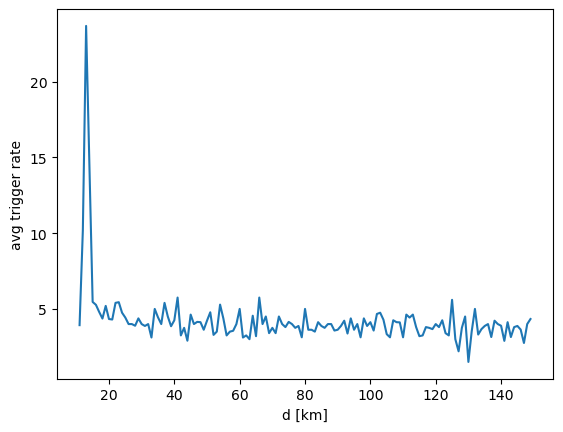

In [18]:
test = sqldf('Select avg(sum_triggers_per_second) as avg_triggers_per_sec, round(d, 0) as d from result_df group by round(d, 0)')
plt.plot(test.d, test.avg_triggers_per_sec)
plt.xlabel('d [km]')
plt.ylabel('avg trigger rate')
#mask = (test.d > 85) & (test.d < 100)
#print(test.d[mask], test.avg_triggers_per_sec[mask])

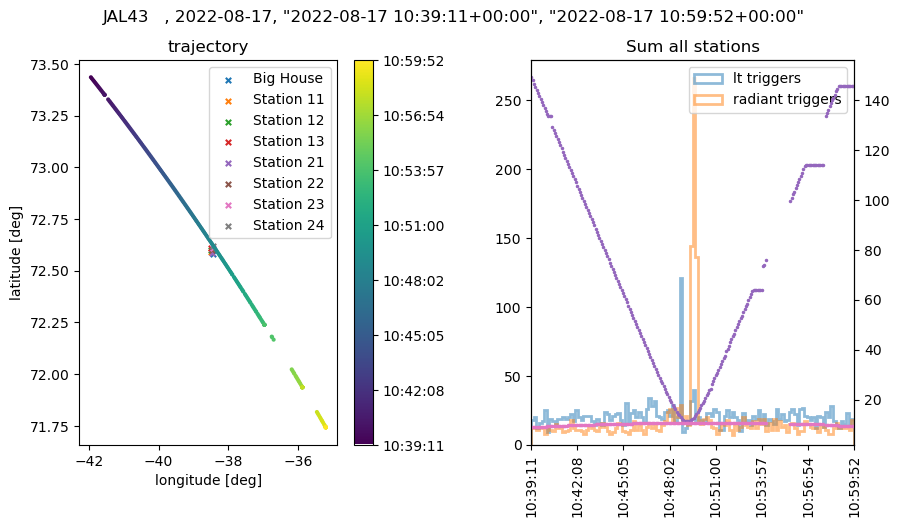

In [55]:
f = tracker.get_flight_by_index(0)
f.plot_flight()

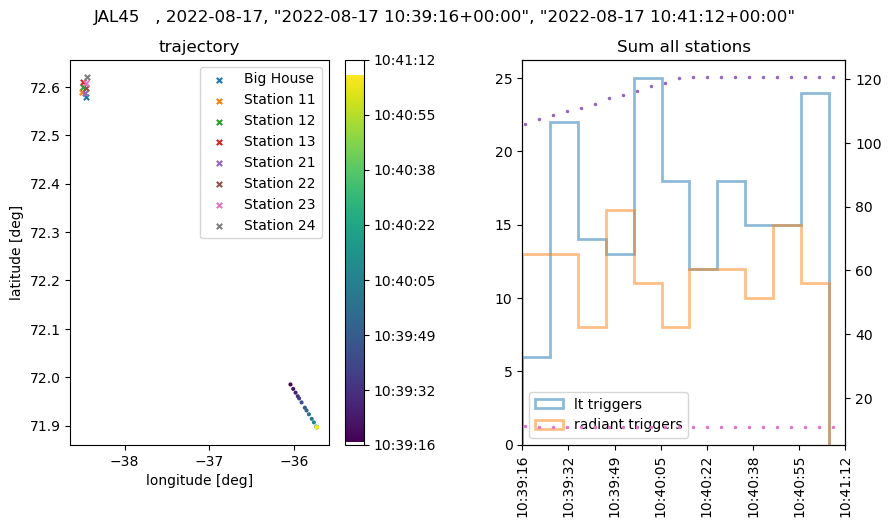

In [56]:
f = tracker.get_flight_by_index(1)
f.plot_flight()

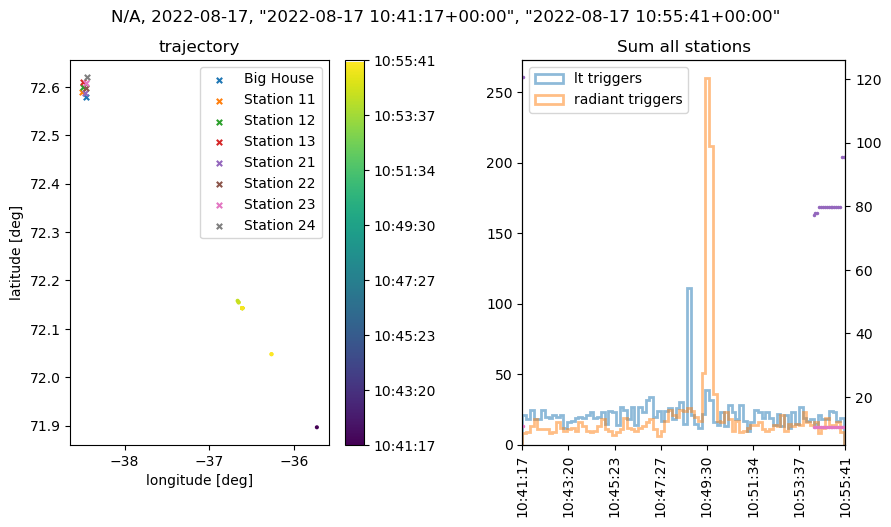

In [57]:
f = tracker.get_flight_by_index(2)
f.plot_flight()

In [6]:
import sqlite3
import pandas as pd
con = sqlite3.connect('./combined_scores_handcarry/station11_run1239.db')
                
# get combined_scores from db file and join on temp_df
temp_scores = pd.read_sql_query("SELECT name from sqlite_master where type = 'table'", con)
#temp_df = temp_df.merge(temp_scores, on=['station_number', 'run_number', 'event_number'], how='left')

# Close the database connection
con.close()
temp_scores

,name


In [3]:
tracker.header_df = FlightTracker.get_df_from_handcarry_data(tracker.start_time, tracker.stop_time)

INFO:runtable_database:database connection to RNOG_live established


DatabaseError: Execution failed on sql 'SELECT * FROM combined_scores': no such table: combined_scores

In [7]:
from Flight import Flight
f'{Flight.path_to_combined_files}'

'/home/oliver/software/Flights/combined/'

In [ ]:
JAL43 = tracker.get_flight_by_index(6, filetype='combined.root')

/home/oliver/anaconda3/envs/work/lib/python3.11/site-packages/ipykernel/kernelbase.py:434: RuntimeWarning: coroutine 'InteractiveShell.run_cell_async' was never awaited
  self.log.error("KeyboardInterrupt caught in kernel.")


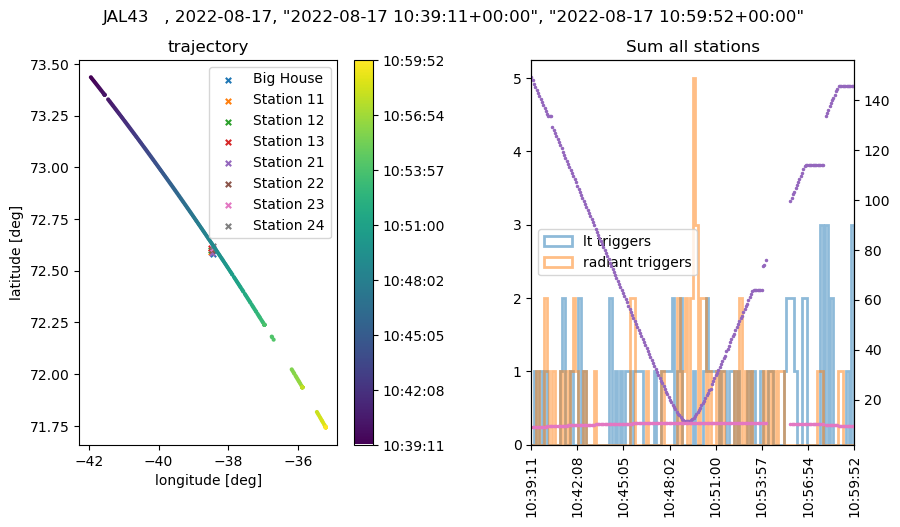

In [ ]:
JAL43.plot_flight()

In [ ]:
JAL43.header_df[JAL43.header_df.impulsive == 1]



,station_number,run_number,event_number,trigger_time,radiant_triggers,lt_triggers,force_triggers,l1_max,amp_max,SNR_max,RMS_max,cw,impulsive
13,12,491,357,1.660733e+09,True,False,False,0.079042,0.236742,16.483842,0.019665,0,1
14,12,491,401,1.660733e+09,True,False,False,0.065601,0.262300,18.263365,0.019665,0,1
34,21,1637,2154,1.660733e+09,True,False,False,0.150634,0.203024,9.284367,0.022619,0,1
35,21,1637,2176,1.660733e+09,True,False,False,0.154948,0.211841,9.687576,0.022619,0,1
38,21,1637,2209,1.660733e+09,True,False,False,0.166670,0.251384,11.113915,0.022619,0,1
39,21,1637,2232,1.660733e+09,True,False,False,0.166626,0.259268,11.955983,0.022619,0,1
48,21,1637,2756,1.660733e+09,True,False,False,0.096771,0.224648,14.233268,0.022619,0,1
52,21,1637,2838,1.660733e+09,True,False,False,0.136001,0.091765,9.538664,0.022619,0,1
54,21,1637,2872,1.660733e+09,True,False,False,0.090507,0.326944,15.632912,0.022619,0,1
55,21,1637,2887,1.660733e+09,True,False,False,0.048944,0.303743,17.036891,0.022619,0,1
